# CNN for Jet Tagging

In this notebook we would be training and evaluating different CNN model architecture through trial and error to obtain the best model for jet tagging.

### Importing modules required

In [6]:
from __future__ import division, print_function
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow import keras
from keras import callbacks
import matplotlib as mpl  
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

In [7]:
from tensorflow import keras
from keras import callbacks
import matplotlib as mpl  
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

### Ensure that Jupyter Notebook is running on local GPU

In [8]:
a = tf.test.gpu_device_name()
if a == "/device:GPU:0":
    print("Jupyter Notebook is running on local GPU")
else:
    print("Jupyter Notebook is not running on local GPU")

Jupyter Notebook is not running on local GPU


### Neural Network configuration

Loss function has to be set to **binary cross-entropy** for classifying model.

Optimizer set to be **adam**.

Number of epochs set to be 20.

In [4]:
np.random.seed(94)
loss_function = 'binary_crossentropy'                      # loss function for model training
vector_length = 40 * 40                                    # image data dimension                             
optimizer = 'adam'                                         # optimizer algorithm for minimising loss
nb_epochs = 20                                             # set number of epochs
multi_gpu_training = False

do_shuffle = True                                          # set shuffle to be True when splitting dataset

input_filename = "20190920_pt600.0_1500.0_40bins_10k.npz"

### Importing image data
10000 jet images from W boson and 10000 background jets image is imported.

In [5]:
print("loading {} feature vector dataset...".format(vector_length))

input_data = np.load(input_filename)

w_samples = input_data['W_jet_images']
qcd_samples = input_data['QCD_jet_images']

print("Number of image for jets from W boson(signal jets):", len(w_samples))
print("Number of image for background jets:",len(qcd_samples))

loading 1600 feature vector dataset...
Number of image for jets from W boson(signal jets): 10000
Number of image for background jets: 10000


### Pre-processing data

First a function for normalising image data is written.

Then each image was label with a vector where [0,1] represents signal jets and [1,0] represents  background jets.

Then image was reshape to have one more array for colour.

It was then split into train, validation and test datasets.

In [6]:
def prepro(data):
    '''
    Function for normalising image data to have a range of pixel intensity of [0,1]
    Input:
    data = data to be normalised
    Output:
    Normalised data
    '''
    normdata=[]
    for i in range (len(data)):
        normdata.append(data[i]/np.max(data[i]))
    return np.asarray(normdata)

In [7]:
test_sample_size = 2500/20000
train_sample_size = 15000/17500

### Loading pre-processing data 

In [8]:
X_BG = qcd_samples                          # image data for background jets
X_S = w_samples                             # image data for signal jets
print(np.shape(X_S))

# Normalised jets
normX_BG = prepro(X_BG) 
normX_S = prepro(X_S)

print("ratio S/BG:", len(X_S) / len(X_BG))

np.random.shuffle(X_BG)

#Labelling
y_S = np.ones(len(X_S))                      # label signal jets
y_BG = np.zeros(len(X_BG))                   # label background jets

# Preparing image data arrays for CNN input with extra colour channel

X = np.append(X_S, X_BG, axis=0)
y = np.append(y_S, y_BG, axis=0)

normX = np.append(normX_S, normX_BG, axis=0)
normy = np.append(y_S, y_BG, axis=0)

X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1) )
normX = normX.reshape( (normX.shape[0], normX.shape[1], normX.shape[2], 1) )

# Split data into training, validation and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sample_size, shuffle=do_shuffle)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_sample_size, shuffle=do_shuffle)
normX_train, normX_test, normy_train, normy_test = train_test_split(normX,normy, test_size=test_sample_size, shuffle=do_shuffle)
normX_train, normX_val, normy_train, normy_val = train_test_split(normX_train,normy_train, train_size=train_sample_size, shuffle=do_shuffle)


# Reshape target vectors into [0,1] and [1,0]
y = to_categorical(y, 2)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

normy = to_categorical(normy, 2)
normy_train = to_categorical(normy_train, 2)
normy_test = to_categorical(normy_test, 2)
normy_val = to_categorical(normy_val, 2)





(10000, 40, 40)
ratio S/BG: 1.0
Input vector shape: (40, 40, 1)
Number of input samples: 20000
Number of train input samples: 15000
Number of validation input samples: 2500
Number of test input samples: 2500


In [13]:
print(X_S.shape[2])

40


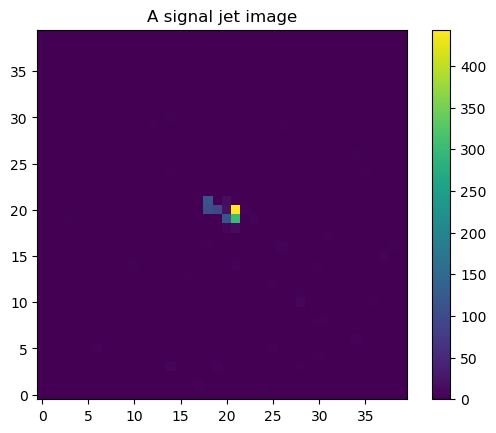

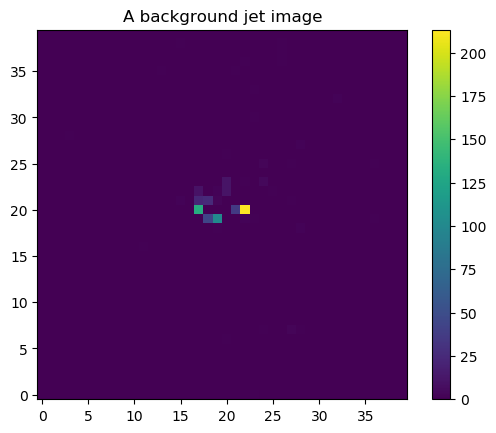

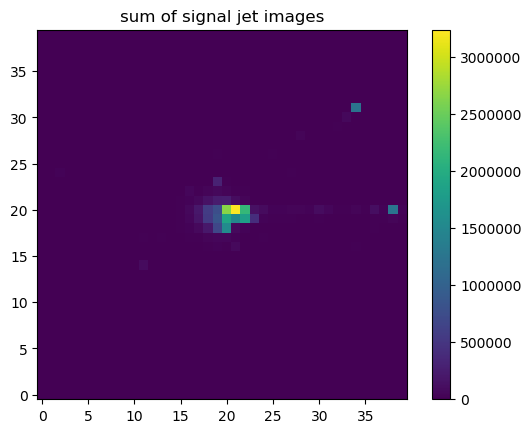

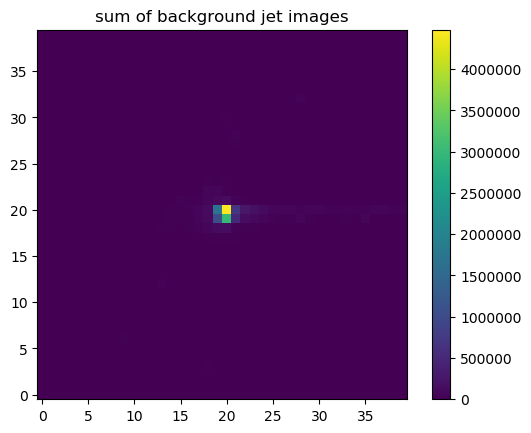

In [9]:
iimg_sig = np.random.randint(0,len(X_S))
iimg_bkg = np.random.randint(0,len(X_BG))
plt.style.use('default')

plt.figure()
plt.title("A signal jet image")
plt.imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("A background jet image")
plt.imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("sum of signal jet images")
plt.imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("sum of background jet images")
plt.imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
plt.colorbar()

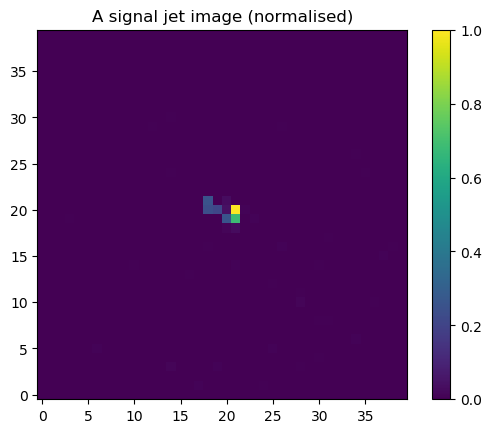

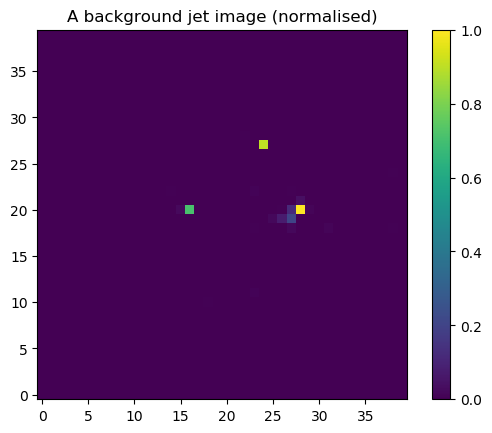

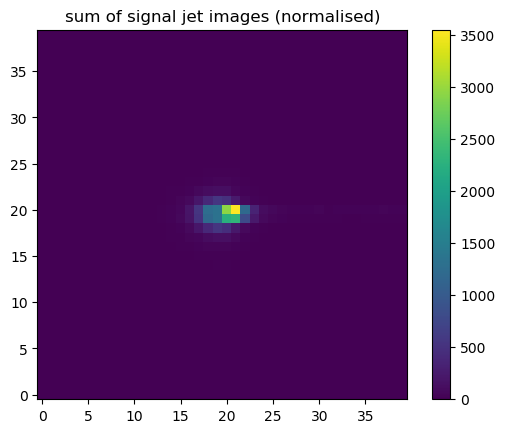

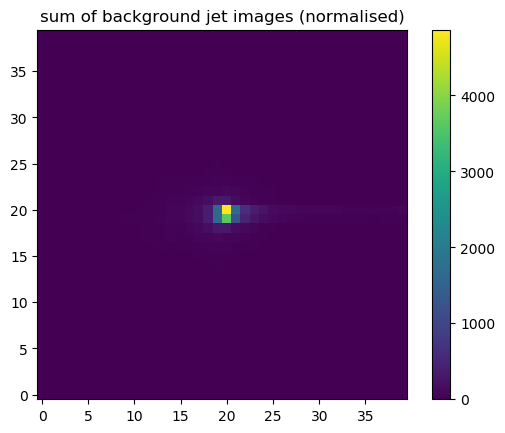

In [10]:
plt.style.use('default')

plt.figure()
plt.title("A signal jet image (normalised)")
plt.imshow(normX_S[iimg_sig].reshape(normX_S.shape[1], normX_S.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("A background jet image (normalised)")
plt.imshow(normX_BG[iimg_bkg].reshape(normX_BG.shape[1], normX_BG.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("sum of signal jet images (normalised)")
plt.imshow(np.sum(normX_S, axis=0).reshape(normX_S.shape[1], normX_S.shape[2]), origin="lower")
plt.colorbar()

plt.figure()
plt.title("sum of background jet images (normalised)")
plt.imshow(np.sum(normX_BG, axis=0).reshape(normX_BG.shape[1], normX_BG.shape[2]), origin="lower")
plt.colorbar()

### Model Architecture

In [11]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', ))
model.add(keras.layers.MaxPooling2D((3, 3)))
model.add(keras.layers.Dropout(rate = 0.2))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu', ))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu', ))
model.add(keras.layers.Conv2D(256, (3,3), activation='relu', ))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(rate = 0.2))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))

model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(rate = 0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", verbose = 1, 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

model.compile(loss=loss_function,optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [12]:
modelnorm=keras.models.Sequential()
modelnorm.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
modelnorm.add(keras.layers.Conv2D(32, (3,3), activation='relu', ))
modelnorm.add(keras.layers.MaxPooling2D((3, 3)))
modelnorm.add(keras.layers.Dropout(rate = 0.2))

modelnorm.add(keras.layers.Conv2D(64, (3,3), activation='relu', ))
modelnorm.add(keras.layers.Conv2D(64, (3,3), activation='relu', ))
modelnorm.add(keras.layers.Conv2D(256, (3,3), activation='relu', ))
modelnorm.add(keras.layers.MaxPooling2D((2, 2)))
modelnorm.add(keras.layers.Dropout(rate = 0.2))


modelnorm.add(keras.layers.Flatten())
modelnorm.add(keras.layers.Dense(256))

modelnorm.add(keras.layers.Activation('relu'))
modelnorm.add(keras.layers.Dropout(rate = 0.2))
modelnorm.add(keras.layers.Dense(2, activation='softmax'))

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", verbose = 1, 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

modelnorm.compile(loss=loss_function,optimizer='adam', metrics=['accuracy'])
modelnorm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 38, 38, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [13]:
modelDLE=keras.models.Sequential()
modelDLE.add(keras.layers.Conv2D(32, (11,11), activation='relu', padding='same', input_shape=input_shape))
modelDLE.add(keras.layers.MaxPooling2D((2, 2)))
modelDLE.add(keras.layers.Dropout(rate = 0.2))

modelDLE.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
modelDLE.add(keras.layers.MaxPooling2D((3, 3)))
modelDLE.add(keras.layers.Dropout(rate = 0.2))

modelDLE.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
modelDLE.add(keras.layers.MaxPooling2D((3, 3)))
modelDLE.add(keras.layers.Dropout(rate = 0.2))


modelDLE.add(keras.layers.Flatten())
modelDLE.add(keras.layers.Dense(64))

modelDLE.add(keras.layers.Activation('relu'))
modelDLE.add(keras.layers.Dropout(rate = 0.1))
modelDLE.add(keras.layers.Dense(2, activation='sigmoid'))

modelDLE.compile(loss=loss_function,optimizer='adam', metrics=['accuracy'])
modelDLE.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 40, 40, 32)        3904      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 32)         

In [14]:
modelZeroPad=keras.models.Sequential()
modelZeroPad.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
modelZeroPad.add(keras.layers.Conv2D(32, (3,3), activation='relu', ))
modelZeroPad.add(keras.layers.MaxPooling2D((3, 3)))
modelZeroPad.add(keras.layers.Dropout(rate = 0.2))

modelZeroPad.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', ))
modelZeroPad.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', ))
modelZeroPad.add(keras.layers.Conv2D(256, (3,3), activation='relu', ))
modelZeroPad.add(keras.layers.MaxPooling2D((2, 2)))
modelZeroPad.add(keras.layers.Dropout(rate = 0.2))


modelZeroPad.add(keras.layers.Flatten())
modelZeroPad.add(keras.layers.Dense(256))

modelZeroPad.add(keras.layers.Activation('relu'))
modelZeroPad.add(keras.layers.Dropout(rate = 0.2))
modelZeroPad.add(keras.layers.Dense(2, activation='softmax'))

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", verbose = 1, 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

modelZeroPad.compile(loss=loss_function,optimizer='adam', metrics=['accuracy'])
modelZeroPad.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 38, 38, 32)        320       
                                                                 
 conv2d_14 (Conv2D)          (None, 36, 36, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 12, 64)        36928     
                                                      

In [16]:
start=datetime.now()
history = model.fit(X_train, y_train, epochs=nb_epochs,batch_size=100, validation_data=(X_val, y_val), shuffle = do_shuffle, verbose=1, callbacks=earlystopping)
runtime = datetime.now()-start

Epoch 1/20
150/150 [==============================] - 4s 27ms/step - loss: 0.9272 - accuracy: 0.6095 - val_loss: 0.6807 - val_accuracy: 0.6500
Epoch 2/20
150/150 [==============================] - 4s 24ms/step - loss: 0.7081 - accuracy: 0.6404 - val_loss: 0.6540 - val_accuracy: 0.6940
Epoch 3/20
150/150 [==============================] - 4s 25ms/step - loss: 0.6587 - accuracy: 0.6828 - val_loss: 0.6411 - val_accuracy: 0.6996
Epoch 4/20
150/150 [==============================] - 4s 26ms/step - loss: 0.5954 - accuracy: 0.7113 - val_loss: 0.5424 - val_accuracy: 0.7404
Epoch 5/20
150/150 [==============================] - 4s 25ms/step - loss: 0.5833 - accuracy: 0.7323 - val_loss: 0.5449 - val_accuracy: 0.7504
Epoch 6/20
150/150 [==============================] - 4s 25ms/step - loss: 0.5570 - accuracy: 0.7474 - val_loss: 0.5133 - val_accuracy: 0.7588
Epoch 7/20
150/150 [==============================] - 4s 25ms/step - loss: 0.5126 - accuracy: 0.7567 - val_loss: 0.5035 - val_accuracy: 0.7632

In [16]:
start=datetime.now()
historynorm = modelnorm.fit(normX_train, normy_train, epochs=nb_epochs,batch_size=100, validation_data=(normX_val, normy_val), shuffle = do_shuffle, verbose=1, callbacks=earlystopping)
runtimenorm = datetime.now()-start

Epoch 1/20
150/150 [==============================] - 5s 27ms/step - loss: 0.5736 - accuracy: 0.7060 - val_loss: 0.5461 - val_accuracy: 0.7584
Epoch 2/20
150/150 [==============================] - 4s 24ms/step - loss: 0.5174 - accuracy: 0.7576 - val_loss: 0.5035 - val_accuracy: 0.7632
Epoch 3/20
150/150 [==============================] - 4s 25ms/step - loss: 0.4993 - accuracy: 0.7683 - val_loss: 0.4911 - val_accuracy: 0.7628
Epoch 4/20
150/150 [==============================] - 4s 24ms/step - loss: 0.4848 - accuracy: 0.7783 - val_loss: 0.4674 - val_accuracy: 0.7820
Epoch 5/20
150/150 [==============================] - 4s 24ms/step - loss: 0.4689 - accuracy: 0.7865 - val_loss: 0.4608 - val_accuracy: 0.7928
Epoch 6/20
150/150 [==============================] - 4s 25ms/step - loss: 0.4651 - accuracy: 0.7879 - val_loss: 0.4583 - val_accuracy: 0.7856
Epoch 7/20
150/150 [==============================] - 4s 25ms/step - loss: 0.4538 - accuracy: 0.7913 - val_loss: 0.4608 - val_accuracy: 0.7876

In [17]:
start=datetime.now()
historyZeroPad = modelZeroPad.fit(normX_train, normy_train, epochs=nb_epochs,batch_size=100, validation_data=(normX_val, normy_val), shuffle = do_shuffle, verbose=1, callbacks=earlystopping)
runtimeZeroPad = datetime.now()-start

Epoch 1/20
150/150 [==============================] - 6s 32ms/step - loss: 0.5813 - accuracy: 0.7041 - val_loss: 0.5101 - val_accuracy: 0.7564
Epoch 2/20
150/150 [==============================] - 5s 31ms/step - loss: 0.5051 - accuracy: 0.7672 - val_loss: 0.4814 - val_accuracy: 0.7716
Epoch 3/20
150/150 [==============================] - 5s 30ms/step - loss: 0.4918 - accuracy: 0.7727 - val_loss: 0.4728 - val_accuracy: 0.7784
Epoch 4/20
150/150 [==============================] - 5s 31ms/step - loss: 0.4788 - accuracy: 0.7813 - val_loss: 0.4771 - val_accuracy: 0.7764
Epoch 5/20
150/150 [==============================] - 5s 32ms/step - loss: 0.4697 - accuracy: 0.7874 - val_loss: 0.4729 - val_accuracy: 0.7904
Epoch 6/20
150/150 [==============================] - 5s 30ms/step - loss: 0.4639 - accuracy: 0.7910 - val_loss: 0.4702 - val_accuracy: 0.7824
Epoch 7/20
150/150 [==============================] - 5s 30ms/step - loss: 0.4570 - accuracy: 0.7945 - val_loss: 0.4529 - val_accuracy: 0.7948

In [18]:
start=datetime.now()
historyDLE = modelDLE.fit(X_train, y_train, epochs=nb_epochs,batch_size=100, validation_data=(X_val, y_val), shuffle = do_shuffle, verbose=1, callbacks=earlystopping)
runtimeDLE = datetime.now()-start

Epoch 1/20
150/150 [==============================] - 4s 19ms/step - loss: 2.4297 - accuracy: 0.5121 - val_loss: 0.7819 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 3s 18ms/step - loss: 1.0630 - accuracy: 0.5314 - val_loss: 0.7199 - val_accuracy: 0.6228
Epoch 3/20
150/150 [==============================] - 3s 18ms/step - loss: 0.8837 - accuracy: 0.5459 - val_loss: 0.7084 - val_accuracy: 0.6532
Epoch 4/20
150/150 [==============================] - 3s 18ms/step - loss: 0.8482 - accuracy: 0.5432 - val_loss: 0.7591 - val_accuracy: 0.5524
Epoch 5/20
150/150 [==============================] - 3s 18ms/step - loss: 0.8385 - accuracy: 0.5547 - val_loss: 0.7304 - val_accuracy: 0.5264
Epoch 6/20
150/150 [==============================] - 3s 18ms/step - loss: 0.7369 - accuracy: 0.5437 - val_loss: 0.7106 - val_accuracy: 0.5040
Epoch 7/20
150/150 [==============================] - 3s 18ms/step - loss: 0.7197 - accuracy: 0.5189 - val_loss: 0.6966 - val_accuracy: 0.5008

### Evaluation

In [19]:
# Model
print("MODEL")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss:", test_loss)
print("test accuracy", test_acc)

prob = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), prob.ravel())
roc_auc = roc_auc_score(y_test,prob)
print("roc score:",roc_auc)

pred_label = to_categorical(np.argmax(prob, axis = 1),2)
f1 = f1_score(y_test, pred_label, average = 'macro')
print("f1 score:", f1)
print(runtime)
print()

# Modelnorm
print("MODEL NORMALIZED")
test_loss_norm, test_acc_norm = modelnorm.evaluate(normX_test, normy_test)
print("test loss:", test_loss_norm)
print("test accuracy", test_acc_norm)

prob_norm = modelnorm.predict(normX_test)
fpr_norm, tpr_norm, thresholds_norm = roc_curve(normy_test.ravel(), prob_norm.ravel())
roc_auc_norm = roc_auc_score(normy_test,prob_norm)
print("roc score:",roc_auc_norm)

pred_label_norm = to_categorical(np.argmax(prob_norm, axis = 1),2)
f1_norm = f1_score(normy_test, pred_label_norm, average = 'macro')
print("f1 score:", f1_norm)
print(runtimenorm)
print()



# ModelZeroPad
print("MODEL ZEROPAD")
test_loss_ZeroPad, test_acc_ZeroPad = modelZeroPad.evaluate(normX_test, normy_test)
print("test loss:", test_loss_ZeroPad)
print("test accuracy", test_acc_ZeroPad)

prob_ZeroPad = modelZeroPad.predict(normX_test)
fpr_ZeroPad, tpr_ZeroPad, thresholds_ZeroPad = roc_curve(normy_test.ravel(), prob_ZeroPad.ravel())
roc_auc_ZeroPad = roc_auc_score(normy_test,prob_ZeroPad)
print("roc score:",roc_auc_ZeroPad)

pred_label_ZeroPad = to_categorical(np.argmax(prob_ZeroPad, axis = 1),2)
f1_ZeroPad = f1_score(y_test, pred_label_ZeroPad, average = 'macro')
print("f1 score:", f1_ZeroPad)
print(runtimeZeroPad)
print()


# Model DeepTop
print("MODEL DLE")
test_loss_DLE, test_acc_DLE = modelDLE.evaluate(X_test, y_test)
print("test loss:", test_loss_DLE)
print("test accuracy", test_acc_DLE)

prob_DLE = modelDLE.predict(X_test)
fpr_DLE, tpr_DLE, thresholds_DLE = roc_curve(y_test.ravel(), prob_DLE.ravel())
roc_auc_DLE = roc_auc_score(y_test,prob_DLE)
print("roc score:",roc_auc_DLE)

pred_label_DLE = to_categorical(np.argmax(prob_DLE, axis = 1),2)
f1_DLE = f1_score(y_test, pred_label_DLE, average = 'macro')
print("DeepTop f1 score:", f1_DLE)
print(runtimeDLE)
print()

MODEL
79/79 [==============================] - 1s 8ms/step - loss: 0.4789 - accuracy: 0.7736
test loss: 0.47893330454826355
test accuracy 0.7735999822616577
roc score: 0.8534291337952664
f1 score: 0.7736000000000001
0:01:22.275508

MODEL NORMALIZED
79/79 [==============================] - 1s 7ms/step - loss: 0.4513 - accuracy: 0.8008
test loss: 0.4513484239578247
test accuracy 0.8008000254631042
roc score: 0.8720058510148074
f1 score: 0.8006999992316145
0:01:04.767565

MODEL ZEROPAD
79/79 [==============================] - 1s 8ms/step - loss: 0.4579 - accuracy: 0.7896
test loss: 0.45788276195526123
test accuracy 0.7896000146865845
roc score: 0.8688129774510005
f1 score: 0.49388914147754925
0:01:10.602775

MODEL DLE
79/79 [==============================] - 1s 8ms/step - loss: 0.6946 - accuracy: 0.5656
test loss: 0.6946110725402832
test accuracy 0.5655999779701233
roc score: 0.6449767166471971
DeepTop f1 score: 0.5253509780392223
0:00:53.655826



Model Norm is chose to be the best model.

### Plotting

#### Plot of loss against epochs and accuracy against epochs to visualise progress of model training

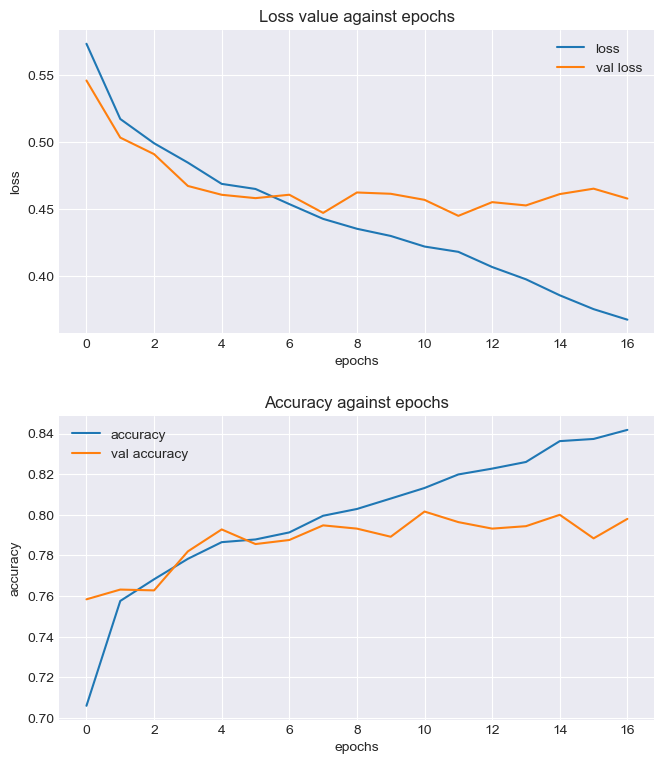

In [25]:
fig, axs = plt.subplots(2, figsize=(7,8))
plt.style.use('seaborn-darkgrid')


axs[0].set_title("Loss value against epochs")
axs[0].plot(historynorm.history['loss'], label='loss')
axs[0].plot(historynorm.history['val_loss'], label='val loss')
axs[0].set(xlabel='epochs', ylabel='loss')
axs[0].legend(loc='best')

axs[1].set_title("Accuracy against epochs")
axs[1].plot(historynorm.history['accuracy'], label='accuracy')
axs[1].plot(historynorm.history['val_accuracy'], label='val accuracy')
axs[1].set(xlabel='epochs', ylabel='accuracy')
axs[1].legend(loc='best')


fig.tight_layout(pad=2.0)

#### Plot of ROC curve and plot of background rejection against tagging efficiency

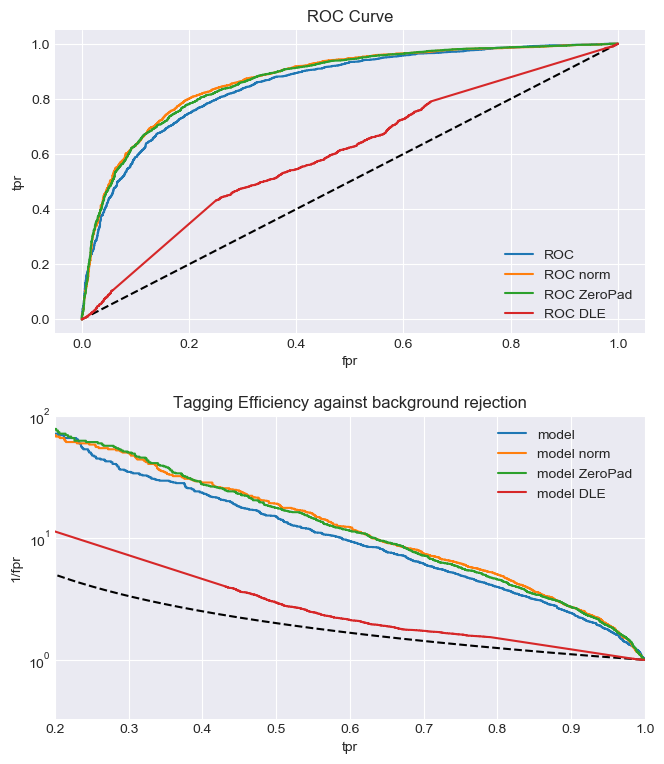

In [21]:
np.seterr(divide='ignore', invalid='ignore')


fig, axs = plt.subplots(2, figsize=(7,8))

axs[0].set_title("ROC Curve")
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot(fpr,tpr, label='ROC')
axs[0].plot(fpr_norm,tpr_norm, label='ROC norm')
axs[0].plot(fpr_ZeroPad,tpr_ZeroPad, label='ROC ZeroPad')
axs[0].plot(fpr_DLE,tpr_DLE, label='ROC DLE')
axs[0].set(xlabel='fpr', ylabel='tpr')
axs[0].legend(loc='best')

axs[1].set_title("Tagging Efficiency against background rejection")
axs[1].set_yscale('log')
axs[1].plot(thresholds, 1/thresholds, 'k--')
axs[1].plot(tpr,1/fpr, label='model')
axs[1].plot(tpr_norm,1/fpr_norm, label='model norm')
axs[1].plot(tpr_ZeroPad,1/fpr_ZeroPad, label='model ZeroPad')
axs[1].plot(tpr_DLE,1/fpr_DLE, label='model DLE')
axs[1].set(xlabel='tpr', ylabel='1/fpr')
axs[1].set_xlim([0.2, 1])
axs[1].set_ylim(top= 10**2)
axs[1].legend(loc='best')

fig.tight_layout(pad=2.0)

Histogram plot of probability obtained using trained model

Text(0, 0.5, 'Counts')

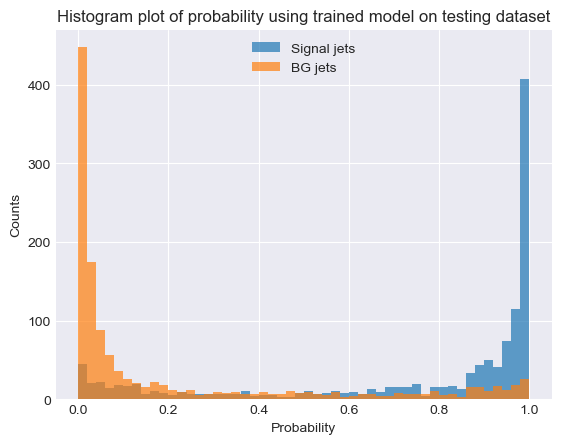

In [35]:
jet_prob_test = []
BG_prob_test = []
prob_test = modelnorm.predict(normX_test)
for i in range(len(normy_test)):
    if normy_test[i][1] == 1:
        jet_prob_test.append(prob_test[i][1])
    else:
        BG_prob_test.append(prob_test[i][1])
        
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.title("Histogram plot of probability using trained model on testing dataset")
n_jet_test, bins_jet_test, patches_jet_test = plt.hist(jet_prob_test, bins=50, label = 'Signal jets', alpha=0.7)
n_BG_test, bins_BG_test, patches_BG_test = plt.hist(BG_prob_test, bins=50, label='BG jets', alpha=0.7)
plt.legend(loc='best')
plt.xlabel("Probability")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

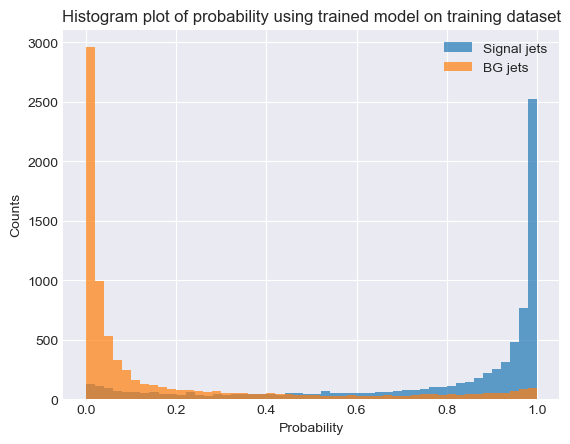

In [36]:
jet_prob_train = []
BG_prob_train = []
prob_train = modelnorm.predict(normX_train)
for i in range(len(normy_train)):
    if normy_train[i][1] == 1:
        jet_prob_train.append(prob_train[i][1])
    else:
        BG_prob_train.append(prob_train[i][1])
        
plt.figure()
plt.style.use('seaborn-darkgrid')
plt.title("Histogram plot of probability using trained model on training dataset")
n_jet_train, bins_jet_train, patches_jet_train = plt.hist(jet_prob_train, bins=50, label = 'Signal jets', alpha=0.7)
n_BG_train, bins_BG_train, patches_BG_train = plt.hist(BG_prob_train, bins=50, label='BG jets', alpha=0.7)
plt.legend(loc='best')
plt.xlabel("Probability")
plt.ylabel("Counts")